Example: Fitting thin film properties 
=========

In this notebook there there are two sections: At first an already trained network is used to fit an example dataset. Below you are able to upload your own dataset.

Model Properties
----
The model used in this example has been trained within the following parameter ranges:
- Number of Layers
- Surface Roughneses?
- ...


Practical notes
----------------------

For those that are new to jupyter notebooks: To use this notebook interactively evalue the cells below one by one (from top to bottom) by activating the cell with the mouse (click) and pressing _Shift_ + _Enter_ to evaluate or click the _"play"-Button_ at the left of each cell.

In [1]:
# import the nesessary python libraries
import numpy as np
import keras
import time
import csv
import warnings

# for imports from inside this git-repro add parent directory to path
import sys
sys.path.append("..")

from ai_reflectivity import xrrplots, config_loader,neural_network
from ai_reflectivity.data_handling import restore_labels
warnings.filterwarnings("ignore", module="tensorflow_backend")

Using TensorFlow backend.


In [2]:
# load config file (here: contains information about the pre-trained network)
config = config_loader.config("../example_data/example.config")

In [3]:


model_file = config.get_model_file()

custom_object_dict = dict(
    [("abs_err_%d" % (i + 1), neural_network.y_absolute_error(i + 1)) for i in range(4)]
)
custom_object_dict["abs_err"] = neural_network.y_absolute_error(0)
model = keras.models.load_model(str(model_file), custom_objects=custom_object_dict)

# import your test data
test_data_file = config.get_experimental_data_file()
test_data = np.loadtxt(test_data_file, delimiter="\t")

q_vector = test_data[:, 0] * 1e10
test_data = test_data[:, 30]

test_input = np.array(test_data,ndmin=2)

test_scores = np.log(test_input)

time_before_prediction = time.perf_counter()
predicted_labels = model.predict(test_scores)
time_after_prediction = time.perf_counter()

labels = restore_labels(predicted_labels)

number_of_layers = int(labels.shape[1] / 3)

thicknesses = labels[:, 0:number_of_layers]
roughnesses = labels[:, number_of_layers : 2 * number_of_layers]
SLDs = labels[:, 2 * number_of_layers : 3 * number_of_layers]

W0820 13:44:21.378138 140399322330944 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 13:44:21.397268 140399322330944 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 13:44:21.547808 140399322330944 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 13:44:21.548525 140399322330944 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

In [4]:
predicted_reflectivity = np.zeros([len(q_vector), 2])
predicted_reflectivity[:, 0] = q_vector

predicted_reflectivity = neural_network.make_reflectivity_curves(
    q_vector, thicknesses, roughnesses, SLDs, 1)

predicted_reflectivity = np.concatenate(
    (np.reshape(q_vector, (q_vector.shape[0], 1)), predicted_reflectivity), axis=1)

prediction_files=config.get_prediction_files()


total_prediction_time = time_after_prediction - time_before_prediction
print(f"Pure prediction time : {total_prediction_time*1000:.2f} ms.\n")
print(f"Layer Thicknesses : {thicknesses *1e9} nm")
print(f"Roughnesses Thicknesses : {thicknesses} m^2")
print(f"SLDs : {SLDs} 1/m^2")


100%|██████████| 1/1 [00:00<00:00, 243.71it/s]

Pure prediction time : 115.44 ms.

Layer Thicknesses : [[7.7662926e+00 9.4998974e-01 1.0000000e+09]] nm
Roughnesses Thicknesses : [[7.7662925e-09 9.4998975e-10 1.0000000e+00]] m^2
SLDs : [[1.1886419e+15 1.7799999e+15 2.0100000e+15]] 1/m^2


<IPython.core.display.Javascript object>


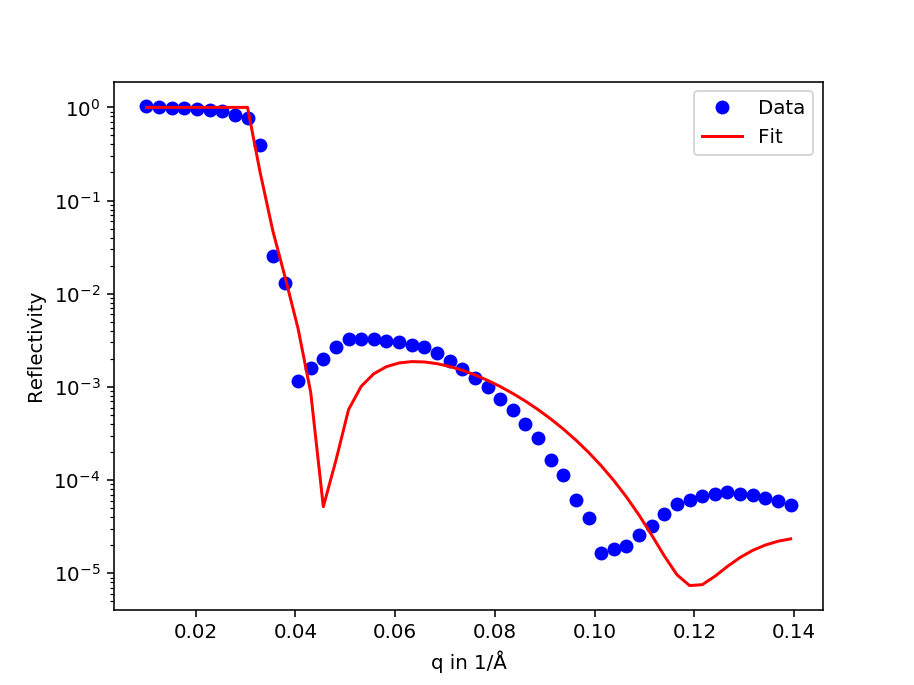

In [5]:
%matplotlib notebook
xrrplots.plot_fit_comparison(
        q_vector, test_data, predicted_reflectivity[:, 1], output="show"
    )


Use your own data
============

in this second section of the notebook you may upload your own reflectivtiy curve and use it with the model loaded above (respect constrains reagarding film thickness etc.)

In [6]:
import ipywidgets as widgets
from IPython.display import display
from io import StringIO
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [7]:
upload=widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(upload)

# As example example_data/dip_single_curve.txt is provided

FileUpload(value={}, description='Upload')

Please use the upload button above to upload your own dataset. The first row will (column-header) will be ignored.

The file should have the following structure:
- first column: scattering vector q  [unit: 1/m]
- second column: reflected intensity [normalized to 1 at q=0]

In [8]:
uploaded=np.loadtxt(StringIO(list(upload.value.values())[0]['content'].decode()), delimiter="\t", skiprows=1)

uploaded_data=uploaded[:,1]
uploaded_q=uploaded[:,0]*1e10

<IPython.core.display.Javascript object>


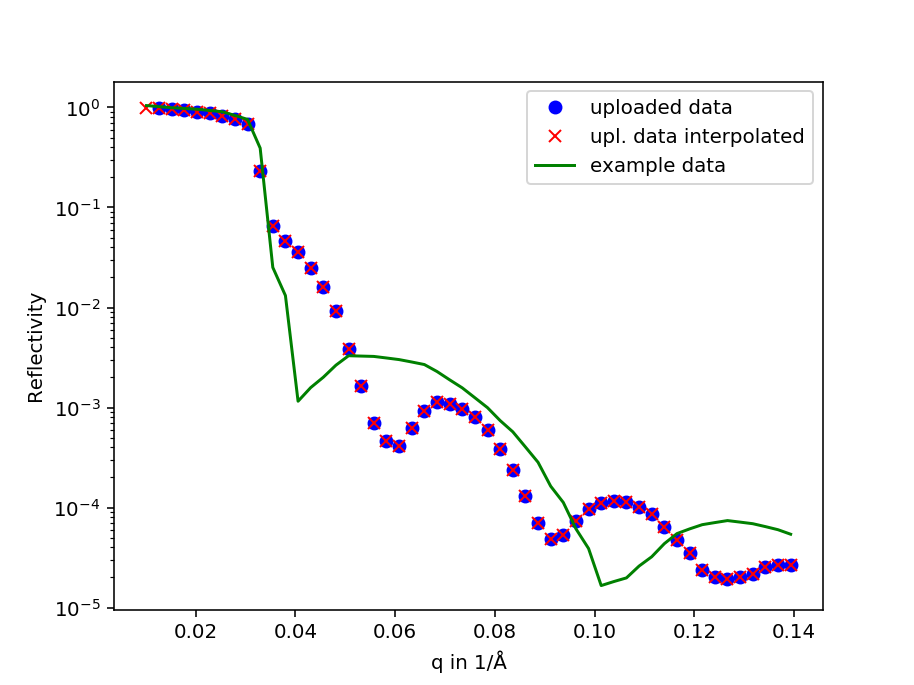

In [9]:
# interpolate to the the same q-values used in the example network used above
# Please note: To work poperly the uploaded properties of the dataset must be
# within the trained regime of the model.

interpol_func=interp1d(np.insert(uploaded_q,0,0),np.insert(uploaded_data,0,1))
interpol_data=interpol_func(q_vector)

plt.figure()
plt.semilogy(uploaded_q * 1e-10 , uploaded_data, "bo", label="uploaded data")
plt.semilogy(q_vector * 1e-10, interpol_data, "rx", label="upl. data interpolated")
plt.semilogy(q_vector * 1e-10, test_data, "g", label="example data")

plt.xlabel("q in 1/Å")
plt.ylabel("Reflectivity")
plt.legend()
plt.show()

In [11]:
test_input_upl = np.array(interpol_data,ndmin=2)

test_scores_upl = np.log(test_input_upl)

time_before_prediction_upl = time.perf_counter()
predicted_labels_upl = model.predict(test_scores_upl)
time_after_prediction_upl = time.perf_counter()

labels_upl = restore_labels(predicted_labels_upl)

number_of_layers_upl = int(labels_upl.shape[1] / 3)

thicknesses_upl = labels_upl[:, 0:number_of_layers]
roughnesses_upl = labels_upl[:, number_of_layers_upl : 2 * number_of_layers_upl]
SLDs_upl = labels_upl[:, 2 * number_of_layers_upl : 3 * number_of_layers_upl]

In [12]:
predicted_reflectivity_upl = np.zeros([len(q_vector), 2])
predicted_reflectivity_upl[:, 0] = q_vector

predicted_reflectivity_upl = neural_network.make_reflectivity_curves(
    q_vector, thicknesses_upl, roughnesses_upl, SLDs_upl, 1)

predicted_reflectivity_upl = np.concatenate(
    (np.reshape(q_vector, (q_vector.shape[0], 1)), predicted_reflectivity_upl), axis=1)

total_prediction_time_upl = time_after_prediction_upl - time_before_prediction_upl
print(f"Pure prediction time : {total_prediction_time_upl*1000:.2f} ms\n")
print(f"Layer Thicknesses : {thicknesses_upl *1e9} nm")
print(f"Roughnesses Thicknesses : {thicknesses_upl} m^2")
print(f"SLDs : {SLDs_upl} 1/m^2")

100%|██████████| 1/1 [00:00<00:00, 289.44it/s]

Pure prediction time : 22.02 ms

Layer Thicknesses : [[1.7411886e+01 1.6071181e+00 1.0000000e+09]] nm
Roughnesses Thicknesses : [[1.7411887e-08 1.6071181e-09 1.0000000e+00]] m^2
SLDs : [[9.410412e+14 1.780000e+15 2.010000e+15]] 1/m^2


<IPython.core.display.Javascript object>


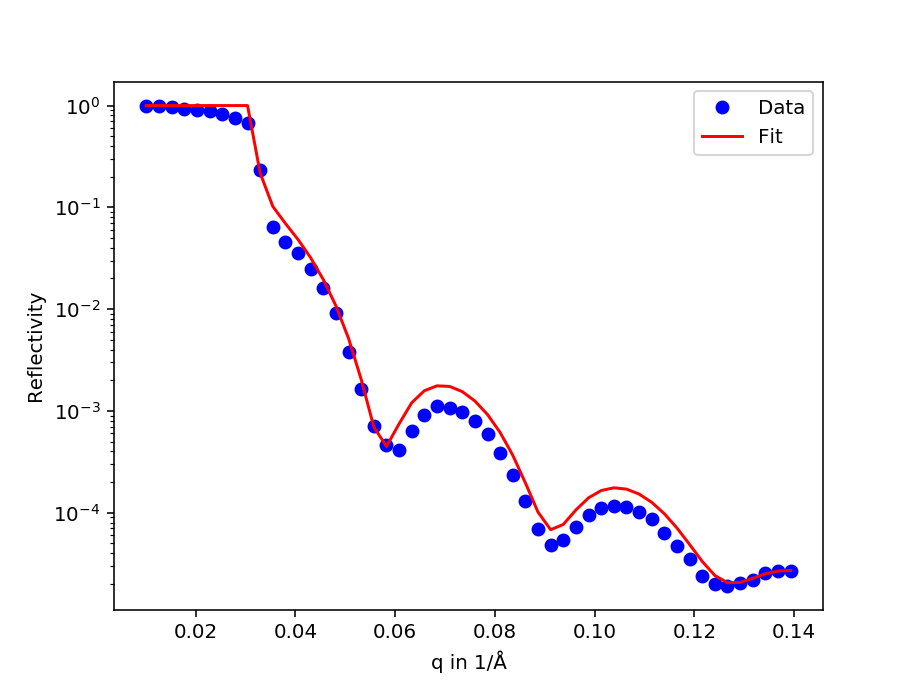

In [13]:
%matplotlib notebook
xrrplots.plot_fit_comparison(
        q_vector, interpol_data, predicted_reflectivity_upl[:, 1] )